In [1]:
!pip install rectools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from rectools import Columns
import requests
import zipfile as zf
import math
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt



## Data preparation

### Extracting KION dataset

In [3]:
url = 'https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip'

req = requests.get(url, stream=True)

with open('kion.zip', 'wb') as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download:   0%|          | 0.00/78.8M [00:00<?, ?iB/s]

In [4]:
files = zf.ZipFile('kion.zip','r')
files.extractall()
files.close()


In [5]:
users = pd.read_csv('data_original/users.csv')
items = pd.read_csv('data_original/items.csv')
interactions = pd.read_csv('data_original/interactions.csv')

### Dataset transformations

In [6]:
# Rename columns
interactions.rename(columns={
    'last_watch_dt': 'datetime',
    'watched_pct': 'weight'
}, inplace=True)

In [7]:
# Drop all rows with non 10 symbols date 
# And transform remaining dates to pandas datetime 
interactions.drop(interactions[interactions[Columns.Datetime].str.len() != 10].index, inplace=True)
interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime], format='%Y-%m-%d')

In [8]:
# Take only little amount interactions
# Because RAM and GPU memory aren't infinite
interactions_df = interactions[interactions['datetime'] < '2021-04-01']

In [9]:
# Take users with 5 and more interactions
users_interactions_count_df = interactions_df.groupby(['user_id', 'item_id']).size().groupby('user_id').size()
print('# users: %d' % len(users_interactions_count_df))
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['user_id']]
print('# users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))

# users: 86614
# users with at least 5 interactions: 14563


In [10]:
# And their interactions
print('# of interactions: %d' % len(interactions_df))
interactions_from_selected_users_df = interactions_df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'user_id',
               right_on = 'user_id')
print('# of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))


# of interactions: 263874
# of interactions from users with at least 5 interactions: 142670


In [11]:
# Smooth weights using logarithm
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['user_id', 'item_id'])['weight'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head(10)


# of unique user/item interactions: 142670


,user_id,item_id,weight
0,21,849,6.375039
1,21,4345,6.658211
2,21,10283,6.658211
3,21,12261,6.658211
4,21,15997,6.658211
5,32,952,6.044394
6,32,4382,4.954196
7,32,4807,6.658211
8,32,10436,6.658211
9,32,12132,6.658211


In [13]:
# Train/Test split
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['user_id'], 
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))


# interactions on Train set: 114136
# interactions on Test set: 28534


In [14]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = interactions_full_df.set_index('user_id')
interactions_train_indexed_df = interactions_train_df.set_index('user_id')
interactions_test_indexed_df = interactions_test_df.set_index('user_id')

In [15]:
# Encode id's
total_df = interactions_train_df.append(interactions_test_indexed_df.reset_index())
total_df['user_id'], users_keys = total_df.user_id.factorize()
total_df['item_id'], items_keys = total_df.item_id.factorize()

train_encoded = total_df.iloc[:len(interactions_train_df)].values
test_encoded = total_df.iloc[len(interactions_train_df):].values

<ipython-input-15-b0e85c64b416>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_df = interactions_train_df.append(interactions_test_indexed_df.reset_index())


In [16]:
shape = [int(total_df['user_id'].max()+1), int(total_df['item_id'].max()+1)]
X_train = csr_matrix((train_encoded[:, 2], (train_encoded[:, 0], train_encoded[:, 1])), shape=shape).toarray()
X_test = csr_matrix((test_encoded[:, 2], (test_encoded[:, 0], test_encoded[:, 1])), shape=shape).toarray()

In [17]:
# Initialize the DataObject, which must return an element (features vector x and target value y)
# for a given idx. This class must also have a length atribute
class UserOrientedDataset(Dataset):
    def __init__(self, X):
        super().__init__() # to initialize the parent class
        self.X = X.astype(np.float32)
        self.len = len(X)

    def __len__(self): # We use __func__ for implementing in-built python functions
        return self.len

    def __getitem__(self, index):
        return self.X[index]

In [22]:
BATCH_SIZE = 3000 # training batch size
EVAL_BATCH_SIZE = 3000 # evaluation batch size.
SEED = 42 # random seed for reproducibility

In [19]:
# Initialize DataLoaders - objects, which sample instances from DataObject-s
train_dl = DataLoader(
    UserOrientedDataset(X_train),
    batch_size = BATCH_SIZE,
    shuffle = True
)

test_dl = DataLoader(
    UserOrientedDataset(X_test),
    batch_size = EVAL_BATCH_SIZE,
    shuffle = False
)

dls = {'train': train_dl, 'test': test_dl}

## Models training

In [20]:
user_vector_len = len(X_train[0])

In [23]:
torch.manual_seed(SEED) # Fix random seed to have reproducible weights of model layers

In [24]:
def rmse_for_sparse(x_pred, x_true):
    mask = (x_true > 0)
    sq_diff = (x_pred * mask - x_true) ** 2
    mse = sq_diff.sum() / mask.sum()
    return mse ** (1/2)

In [25]:
class AERecommender:
    
    MODEL_NAME = 'Autoencoder'
    
    def __init__(self, X_preds, X_train_and_val, X_test):

        self.X_preds = X_preds.cpu().detach().numpy()
        self.X_train_and_val = X_train_and_val
        self.X_test = X_test
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_select_idx, topn=10, verbose=False):
        user_preds = self.X_preds[user_id][items_to_select_idx]
        items_idx = items_to_select_idx[np.argsort(-user_preds)[:topn]]

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        return items_idx

    def evaluate(self, size=100):

        X_total = self.X_train_and_val + self.X_test

        true_5 = []
        true_10 = []

        for user_id in range(len(X_test)):
            non_zero = np.argwhere(self.X_test[user_id] > 0).ravel()
            all_nonzero = np.argwhere(X_total[user_id] > 0).ravel()
            select_from = np.setdiff1d(np.arange(X_total.shape[1]), all_nonzero)

            for non_zero_idx in non_zero:
                random_non_interacted_items = np.random.choice(select_from, size, replace=False)
                preds = self.recommend_items(user_id, np.append(random_non_interacted_items, non_zero_idx), topn=10)
                true_5.append(non_zero_idx in preds[:5])
                true_10.append(non_zero_idx in preds)

        return {"recall@5": np.mean(true_5), "recall@10": np.mean(true_10)}
    



In [39]:
def train_model(model, model_name):
  # Initialize GD method, which will update the weights of the model
  optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
  # Initialize learning rate scheduler, which will decrease LR according to some rule
  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)
  
  # Training loop
  metrics_dict = {
      "Epoch": [],
      "Train RMSE": [],
      "Test RMSE": [],
  }

  # Train loop
  for epoch in range(NUM_EPOCHS):
      metrics_dict["Epoch"].append(epoch)
      for stage in ['train', 'test']:
          with torch.set_grad_enabled(stage == 'train'): # Whether to start building a graph for a backward pass
              if stage == 'train':
                  model.train() # Enable some "special" layers (will speak about later)
              else:
                  model.eval() # Disable some "special" layers (will speak about later)

              loss_at_stage = 0 
              for batch in dls[stage]:
                  batch = batch.to(DEVICE)
                  x_pred = model(batch) # forward pass: model(x_batch) -> calls forward()
                  loss = rmse_for_sparse(x_pred, batch) # ¡Important! y_pred is always the first arg
                  if stage == "train":
                      loss.backward() # Calculate the gradients of all the parameters wrt loss
                      optimizer.step() # Update the parameters
                      scheduler.step()
                      optimizer.zero_grad() # Zero the saved gradient
                  loss_at_stage += loss.item() * len(batch)
              rmse_at_stage = (loss_at_stage / len(dls[stage].dataset)) ** (1/2)
              metrics_dict[f"{stage.title()} RMSE"].append(rmse_at_stage)

  with torch.no_grad():
    X_pred = model(torch.Tensor(X_test).cuda())

  ae_recommender_model = AERecommender(X_pred, X_train, X_test)
  ae_global_metrics = ae_recommender_model.evaluate()
  recall_5, recall_10 = ae_global_metrics["recall@5"], ae_global_metrics["recall@10"]

  print(f"Model: {model_name}, Optim: {optimizer}, Sched: {scheduler}")
  print(f"Recall@5: {recall_5}, Recall@10: {recall_10}")
  print()

  return metrics_dict

In [41]:
# Constants

LR = 1e-3 # learning rate, controls the speed of the training
WEIGHT_DECAY = 0.01 # lambda for L2 reg. ()
NUM_EPOCHS = 100 # num training epochs (how many times each instance will be processed)
GAMMA = 0.9995 # learning rate scheduler parameter

DEVICE = 'cuda' #'cuda' # device to make the calculations on

In [32]:
HIDDEN_SIZE_1 = 1024
HIDDEN_SIZE_2 = 512
HIDDEN_SIZE_3 = 256

### Four different architectures

In [33]:
class TwoLayerAutoEncoderWithLReLU(nn.Module):
  def __init__(self, in_and_out_features):
    super().__init__()
    self.in_and_out_features = in_and_out_features

    self.sequential = nn.Sequential( 
      nn.Linear(in_and_out_features, HIDDEN_SIZE_1), 
      nn.LeakyReLU(), 
      nn.Linear(HIDDEN_SIZE_1, HIDDEN_SIZE_2),
      nn.LeakyReLU(),
      nn.Linear(HIDDEN_SIZE_2, HIDDEN_SIZE_1),
      nn.LeakyReLU(),
      nn.Linear(HIDDEN_SIZE_1, in_and_out_features) 
    )

  def forward(self, x): 
    x = self.sequential(x)
    return x

In [34]:
class ThreeLayerAutoEncoderWithLReLU(nn.Module):
  def __init__(self, in_and_out_features):
    super().__init__()
    self.in_and_out_features = in_and_out_features

    self.sequential = nn.Sequential( 
      nn.Linear(in_and_out_features, HIDDEN_SIZE_1), 
      nn.LeakyReLU(),
      nn.Linear(HIDDEN_SIZE_1, HIDDEN_SIZE_2),
      nn.LeakyReLU(),
      nn.Linear(HIDDEN_SIZE_2, HIDDEN_SIZE_3),
      nn.LeakyReLU(),
      nn.Linear(HIDDEN_SIZE_3, HIDDEN_SIZE_2),
      nn.LeakyReLU(),
      nn.Linear(HIDDEN_SIZE_2, HIDDEN_SIZE_1),
      nn.LeakyReLU(),
      nn.Linear(HIDDEN_SIZE_1, in_and_out_features) 
    )

  def forward(self, x): 
    x = self.sequential(x)
    return x

In [35]:
class TwoLayerAutoEncoderWithTanh(nn.Module):
  def __init__(self, in_and_out_features):
    super().__init__()
    self.in_and_out_features = in_and_out_features

    self.sequential = nn.Sequential( 
      nn.Linear(in_and_out_features, HIDDEN_SIZE_1), 
      nn.Tanh(), 
      nn.Linear(HIDDEN_SIZE_1, HIDDEN_SIZE_2),
      nn.Tanh(),
      nn.Linear(HIDDEN_SIZE_2, HIDDEN_SIZE_1),
      nn.Tanh(),
      nn.Linear(HIDDEN_SIZE_1, in_and_out_features) 
    )

  def forward(self, x): 
    x = self.sequential(x)
    return x

In [36]:
class ThreeLayerAutoEncoderWithTanh(nn.Module):
  def __init__(self, in_and_out_features):
    super().__init__()
    self.in_and_out_features = in_and_out_features

    self.sequential = nn.Sequential( 
      nn.Linear(in_and_out_features, HIDDEN_SIZE_1), 
      nn.Tanh(),
      nn.Linear(HIDDEN_SIZE_1, HIDDEN_SIZE_2),
      nn.Tanh(),
      nn.Linear(HIDDEN_SIZE_2, HIDDEN_SIZE_3),
      nn.Tanh(),
      nn.Linear(HIDDEN_SIZE_3, HIDDEN_SIZE_2),
      nn.Tanh(),
      nn.Linear(HIDDEN_SIZE_2, HIDDEN_SIZE_1),
      nn.Tanh(),
      nn.Linear(HIDDEN_SIZE_1, in_and_out_features) 
    )

  def forward(self, x): 
    x = self.sequential(x)
    return x

In [37]:
# Initialize models
two_layer_lrelu = TwoLayerAutoEncoderWithLReLU(user_vector_len)
three_layer_lrelu = ThreeLayerAutoEncoderWithLReLU(user_vector_len)
two_layer_tanh = TwoLayerAutoEncoderWithTanh(user_vector_len)
three_layer_tanh = ThreeLayerAutoEncoderWithTanh(user_vector_len)

two_layer_lrelu.to(DEVICE)
three_layer_lrelu.to(DEVICE)
two_layer_tanh.to(DEVICE)
three_layer_tanh.to(DEVICE)

ThreeLayerAutoEncoderWithTanh(
  (sequential): Sequential(
    (0): Linear(in_features=8287, out_features=1024, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): Tanh()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): Tanh()
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): Tanh()
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): Tanh()
    (10): Linear(in_features=1024, out_features=8287, bias=True)
  )
)

### Two Layer Autoencoder with LeakyReLU activation

In [42]:
metrics_1 = train_model(two_layer_lrelu, "TwoLayerAutoEncoderWithLReLU")

Model: TwoLayerAutoEncoderWithLReLU, Optim: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.0007787520933134588
    maximize: False
    weight_decay: 0.01
), Sched: <torch.optim.lr_scheduler.ExponentialLR object at 0x7fea1c24e2e0>
Recall@5: 0.532970901126408, Recall@10: 0.635677409261577



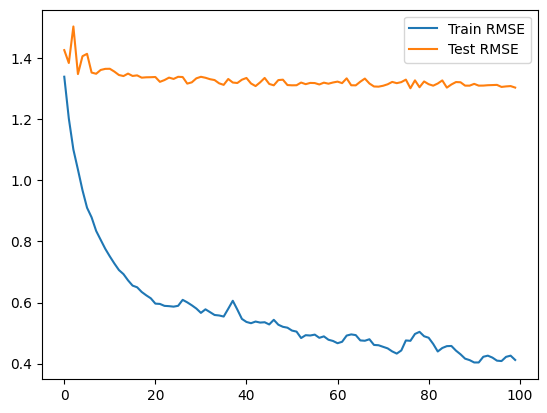

In [50]:
plt.plot(metrics_1["Epoch"], metrics_1["Train RMSE"], label = "Train RMSE")
plt.plot(metrics_1["Epoch"], metrics_1["Test RMSE"], label = "Test RMSE")
plt.legend()
plt.show()

### Three Layer Autoencoder with LeakyReLU activation

In [53]:
metrics_2 = train_model(three_layer_lrelu, "ThreeLayerAutoEncoderWithLReLU")

Model: ThreeLayerAutoEncoderWithLReLU, Optim: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.0007787520933134588
    maximize: False
    weight_decay: 0.01
), Sched: <torch.optim.lr_scheduler.ExponentialLR object at 0x7fe9eb773910>
Recall@5: 0.14760638297872342, Recall@10: 0.29967146433041303



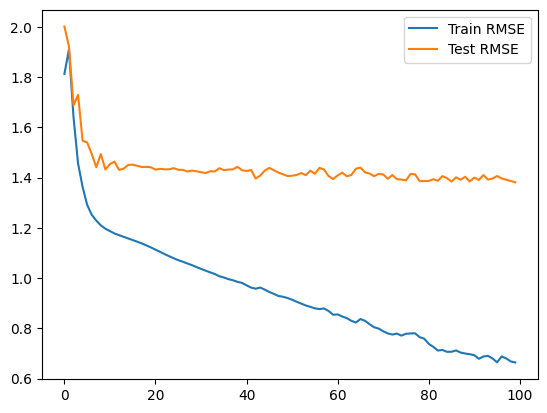

In [55]:
plt.plot(metrics_2["Epoch"], metrics_2["Train RMSE"], label = "Train RMSE")
plt.plot(metrics_2["Epoch"], metrics_2["Test RMSE"], label = "Test RMSE")
plt.legend()
plt.show()

### Two Layer Autoencoder with Tanh activation

In [56]:
metrics_3 = train_model(two_layer_tanh, "TwoLayerAutoEncoderWithTanh")

Model: TwoLayerAutoEncoderWithTanh, Optim: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.0007787520933134588
    maximize: False
    weight_decay: 0.01
), Sched: <torch.optim.lr_scheduler.ExponentialLR object at 0x7fe9eb771f10>
Recall@5: 0.6607869211514393, Recall@10: 0.7378363579474343



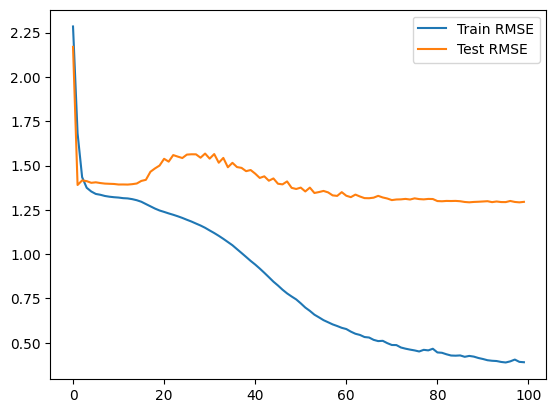

In [57]:
plt.plot(metrics_3["Epoch"], metrics_3["Train RMSE"], label = "Train RMSE")
plt.plot(metrics_3["Epoch"], metrics_3["Test RMSE"], label = "Test RMSE")
plt.legend()
plt.show()

### Three Layer Autoencoder with Tanh activation

In [58]:
metrics_4 = train_model(three_layer_tanh, "ThreeLayerAutoEncoderWithTanh")

Model: ThreeLayerAutoEncoderWithTanh, Optim: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.0007787520933134588
    maximize: False
    weight_decay: 0.01
), Sched: <torch.optim.lr_scheduler.ExponentialLR object at 0x7fe9eb7900a0>
Recall@5: 0.016153003754693366, Recall@10: 0.03699937421777222



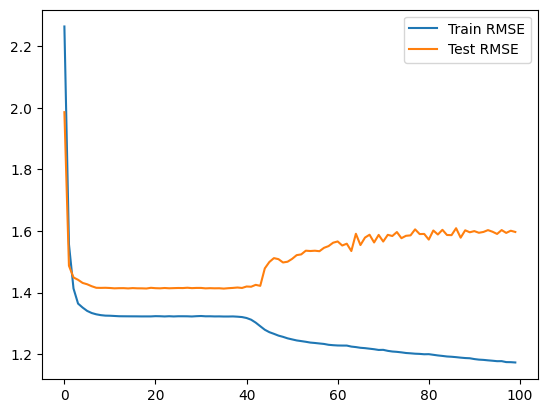

In [59]:
plt.plot(metrics_4["Epoch"], metrics_4["Train RMSE"], label = "Train RMSE")
plt.plot(metrics_4["Epoch"], metrics_4["Test RMSE"], label = "Test RMSE")
plt.legend()
plt.show()

## Итог

2 слоя + LeakyReLU: Recall@5: 0.53 Recall@10: 0.64

3 слоя + LeakyReLU: Recall@5: 0.15 Recall@10: 0.3

2 слоя + Tanh: Recall@5: 0.66 Recall@10: 0.74

3 слоя + Tanh: Recall@5: 0.02 Recall@10: 0.04

Лучшие метрики показал автоэнкодер с 2 слоями и активацией Tanh